<a href="https://colab.research.google.com/github/shyoonCS/DataAnalysis/blob/main/%EB%94%A5%EB%9F%AC%EB%8B%9D_Perceptron_iris.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

코드1-1[1] 필요한 패키지 불러오기

In [44]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_iris

코드1-1[2] 데이터 준비 함수 정의하기

In [53]:
def prepare_data(target):
    iris = load_iris()          # iris data set 읽기
    X_tr = iris.data[:, 2:]     # 4개의 특징 중 꽃잎의 길이와 폭 선택(3번째, 4번째)
    labels = iris.target_names  # 'setosa', 'versicolor', 'virginica'
    y = iris.target

    # 학습표본의 레이블 지정 - target에 지정된 레이블이면 1, 그 외는 0
    y_tr = []
    for i in range(150):
        y_tr.append(labels[y[i]] == target)
    y_tr = np.array(y_tr, dtype=int)
    return X_tr, y_tr, ['(1) '+target, '(0) the others']

코드1-1[3] 활성함수 - 단위 계단 함수

In [46]:
# 활성 함수 - 단위 계단 함수
def step(x):
    return int(x >= 0)

코드1-1[4] 퍼셉트론 객체를 만들기 위한 클래스 선언하기

In [47]:
class Perceptron():
    def __init__(self, dim, activation):
        rnd = np.random.default_rng()
        self.dim = dim #입력층 입력의 수(특징 개수 -> 길이와 폭 2개)
        self.activation = activation
        # 가중치(w)와 바이어스(b)를 He normal 방식으로 초기화
        self.w = rnd.normal(scale = np.sqrt(2.0 / dim), size=dim)
        self.b = rnd.normal(scale = np.sqrt(2.0 / dim))

    def printW(self):
        for i in range(self.dim):
            print('  w{} = {:6.3f}'.format(i+1, self.w[i]), end='')
        print('  b = {:6.3f}'.format(self.b))

    def predict(self, x):  # numpy 배열 x에 저장된 표본의 출력 계산
        return np.array([self.activation(np.dot(self.w, x[i]) + self.b)
                          for i in range(len(x))])

    def fit(self, X, y, N, epochs, eta=0.01):
        # 학습표본의 인덱스를 무작위 순서로 섞음
        idx = list(range(N))
        np.random.shuffle(idx)
        X = np.array([X[idx[i]] for i in range(N)])
        y = np.array([y[idx[i]] for i in range(N)])

        f = 'Epochs = {:4d}    Loss = {:8.5f}'
        print('w의 초깃값  ', end='')
        self.printW()
        for j in range(epochs):
            for i in range(N):
                # x[i]에 대한 출력 오차 계산
                delta = self.predict([X[i]])[0] - y[i]
                self.w -= eta * delta * X[i] #가중치 w 업데이트
                self.b -= eta * delta        #바이어스 b 업데이트
            # 학습 과정 출력
            if j < 10 or (j+1) % 100 == 0:
                loss = self.predict(X) - y
                loss = (loss * loss).sum() / N #MSE 평균 제곱 오차 계산
                print(f.format(j+1, loss), end='')
                self.printW()

코드1-1[5] 모델 시각화

In [48]:
def visualize(net, X, y, multi_class, labels, class_id, colors,xlabel, ylabel, legend_loc='lower right'):
    # 데이터의 최소~최대 범위를 0.05 간격의 좌표값으로 나열
    x_max = np.ceil(np.max(X[:, 0])).astype(int)
    x_min = np.floor(np.min(X[:, 0])).astype(int)
    y_max = np.ceil(np.max(X[:, 1])).astype(int)
    y_min = np.floor(np.min(X[:, 1])).astype(int)
    x_lin = np.linspace(x_min, x_max, (x_max-x_min)*20+1)
    y_lin = np.linspace(y_min, y_max, (y_max-y_min)*20+1)

    # x_lin과 y_lin의 격자좌표의 x와 y 값 구하기
    x_mesh, y_mesh = np.meshgrid(x_lin, y_lin)

    # (x, y) 좌표의 배열로 만들어 신경망의 입력 구성
    X_test = np.column_stack([x_mesh.ravel(), y_mesh.ravel()])

    # 학습된 신경망으로 X_test에 대한 출력 계산
    if multi_class:
        y_hat = net.predict(X_test)
        y_hat = np.array([np.argmax(y_hat[k])
                            for k in range(len(y_hat))], dtype=int)
    else:
        y_hat = (net.predict(X_test) >= 0.5).astype(int)
        y_hat = y_hat.reshape(len(y_hat))

    # 출력할 그래프의 수평/수직 범위 설정
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    # 클래스별로 산점도 그리기
    for c, i, c_name in zip(colors, labels, class_id):
        # 격자 좌표의 클래스별 산점도
        plt.scatter(X_test[y_hat == i, 0], X_test[y_hat == i, 1],
                     c = c, s = 5, alpha = 0.3, edgecolors = 'none')
        # 학습 표본의 클래스별 산점도
        plt.scatter(X[y == i, 0], X[y == i, 1],
                     c = c, s = 20, label=c_name)
    # 범례의 표시 위치 지정
    plt.legend(loc=legend_loc)

    # x축과 y축의 레이블을 지정한 후 그래프 출력
    plt.xlabel(xlabel, size=12)
    plt.ylabel(ylabel, size=12)
    plt.show()

코드1-1[6] 훈련 데이터 준비하기

In [62]:
nSamples = 150
nDim = 2 #꽃잎의 길이와 너비
target = 'setosa' #식별하고자 하는 붓꽃 종류 지정
X_tr, y_tr, labels = prepare_data(target)

{'data': array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
     

코드1-1[7] 퍼셉트론 객체 생성 및 학습

In [50]:
p = Perceptron(nDim, activation=step)
p.fit(X_tr, y_tr, nSamples, epochs=1000, eta=0.01)

w의 초깃값    w1 = -1.834  w2 = -0.741  b =  1.720
Epochs =    1    Loss =  0.05333  w1 = -1.235  w2 = -0.638  b =  2.120
Epochs =    2    Loss =  0.02000  w1 = -1.130  w2 = -0.614  b =  2.180
Epochs =    3    Loss =  0.00667  w1 = -1.092  w2 = -0.608  b =  2.200
Epochs =    4    Loss =  0.00667  w1 = -1.073  w2 = -0.604  b =  2.210
Epochs =    5    Loss =  0.00667  w1 = -1.054  w2 = -0.600  b =  2.220
Epochs =    6    Loss =  0.00000  w1 = -1.035  w2 = -0.596  b =  2.230
Epochs =    7    Loss =  0.00000  w1 = -1.035  w2 = -0.596  b =  2.230
Epochs =    8    Loss =  0.00000  w1 = -1.035  w2 = -0.596  b =  2.230
Epochs =    9    Loss =  0.00000  w1 = -1.035  w2 = -0.596  b =  2.230
Epochs =   10    Loss =  0.00000  w1 = -1.035  w2 = -0.596  b =  2.230
Epochs =  100    Loss =  0.00000  w1 = -1.035  w2 = -0.596  b =  2.230
Epochs =  200    Loss =  0.00000  w1 = -1.035  w2 = -0.596  b =  2.230
Epochs =  300    Loss =  0.00000  w1 = -1.035  w2 = -0.596  b =  2.230
Epochs =  400    Loss =  0.000

코드1-1[8] 특징 공간 결정 영역 시각화

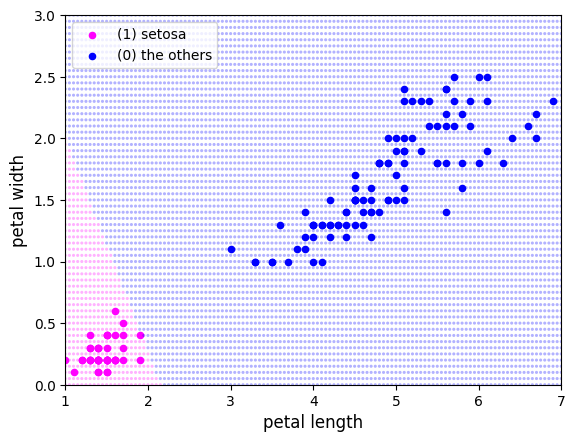

In [51]:
# 학습표본의 순서를 섞거나 연결 가중치 및 바이어스 초깃값을 정할 때 무작위 수를 이용하고 있으며, 이에 따른 학습 결과는 일정하지 않다.
visualize(p, X_tr, y_tr,
          multi_class = False,
          class_id = labels,
          labels = [1, 0],
          colors = ['magenta', 'blue'],
          xlabel = 'petal length',
          ylabel = 'petal width',
          legend_loc = 'upper left')

주관식 1.

In [63]:
#def prepar_data1(N)
c = np.array([[1,2],[2,1]])
X = []
y = []
rnd = np.random.default_rng()
# 각 클래스의 평균 좌표에 무작위 값 더하여 학습표본 집합 생성
for i in range(N)

Generator(PCG64) at 0x78294A533300